# Klasifikasi Kemacetan Lalu Lintas Kota Bogor

## Latar Belakang

Kota Bogor merupakan salah satu kota yang padat penduduknya di Provinsi Jawa Barat, Indonesia. Seiring dengan pertumbuhan jumlah penduduk dan kendaraan di kota Bogor, kemacetan lalu lintas menjadi masalah yang semakin meningkat.

Untuk mengatasi masalah kemacetan lalu lintas di kota Bogor, perlu dilakukan klasifikasi tingkat kemacetan lalu lintas di beberapa ruas jalan utama. Klasifikasi ini bertujuan untuk memberikan informasi kepada pihak terkait mengenai tingkat kepadatan lalu lintas pada suatu ruas jalan pada waktu tertentu, sehingga dapat dilakukan penanganan dan perencanaan lalu lintas yang lebih baik.

Hasil klasifikasi tingkat kemacetan lalu lintas ini dapat digunakan sebagai dasar dalam mengambil keputusan terkait penanganan dan perencanaan lalu lintas yang lebih efektif dan efisien di kota Bogor.

## Dataset

Dataset yang digunakan pada projeck ini adalah crowdsourced/user generated data program Waze for Cities dari Waze

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

## Data Preparation

Pada data preparation terdapat beberapa tahap yaitu:

- import dataset
- memilih/menghapus kolom yang tidak digunakan
- melakukan transformasi data

In [2]:
# Lokasi Dataset
path = '../Modelling/aggregate_median_jams_Kota Bogor.csv'

In [3]:
# Import Dataset
df = pd.read_csv(path)

In [4]:
# Melihat unique value
df.nunique()

Unnamed: 0                    79364
time                           1465
kemendagri_kabupaten_kode         1
kemendagri_kabupaten_nama         1
street                          454
level                             5
median_length                  3845
median_delay                   1641
median_speed_kmh               9397
total_records                   197
id                           102322
date                             62
median_level                      5
geometry                      81959
dtype: int64

In [5]:
# Memilih feature yang akan digunakan
df1 = df.copy()
df1 = df1[['street', 'median_length', 'median_delay', 'median_speed_kmh', 'total_records', 'level']]
df1.head()

,street,median_length,median_delay,median_speed_kmh,total_records,level
0,Pahlawan,784.0,62.0,20.310001,4,2
1,Tol Lingkar Luar Bogor,1314.0,63.0,37.710000,2,2
2,KH Soleh Iskandar (Jalur Lambat),167.0,-1.0,0.000000,61,5
3,N8 Jalan Raya Sukabumi,379.0,117.5,8.594999,10,3
4,Tol Lingkar Luar Bogor,2438.0,87.0,42.270000,2,1


In [6]:
# Melihat deskripsi masing-masing feature
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102322 entries, 0 to 102321
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   street            100529 non-null  object 
 1   median_length     102322 non-null  float64
 2   median_delay      102322 non-null  float64
 3   median_speed_kmh  102322 non-null  float64
 4   total_records     102322 non-null  int64  
 5   level             102322 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 4.7+ MB


## Exploratory Data Analysis

In [7]:
# Statistika Deskriptif
df1.describe()

,median_length,median_delay,median_speed_kmh,total_records,level
count,102322.000000,102322.000000,102322.000000,102322.000000,102322.000000
mean,840.802794,131.969029,14.084945,17.575673,2.433758
std,549.866997,109.430777,7.975882,20.682176,1.002043
min,13.000000,-1.000000,0.000000,1.000000,1.000000
25%,444.000000,75.000000,7.885000,4.000000,2.000000
50%,727.000000,98.000000,13.060000,10.000000,2.000000
75%,1138.000000,145.500000,19.090000,23.000000,3.000000
max,8307.000000,2754.000000,63.614998,600.000000,5.000000


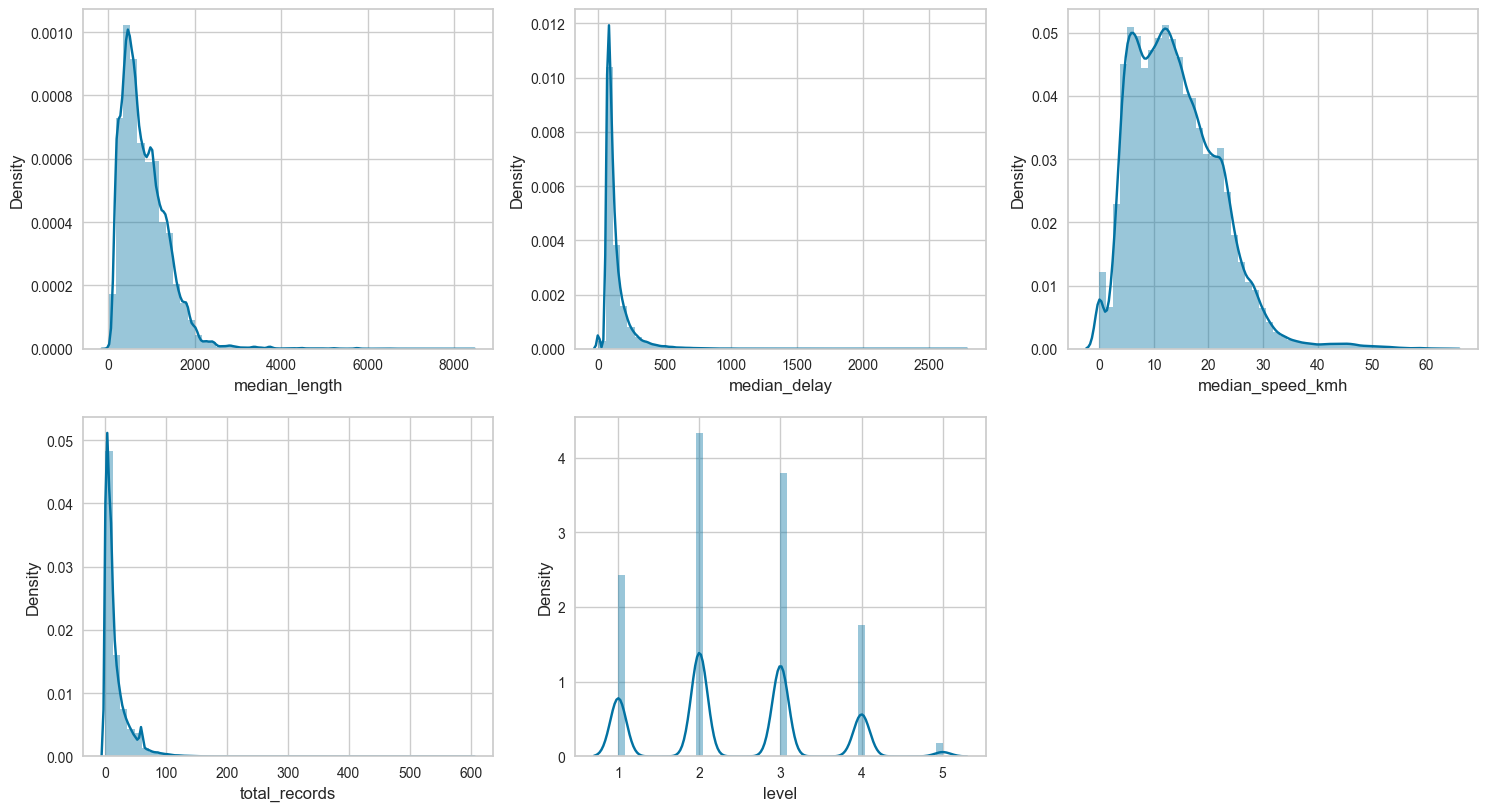

In [8]:
plt.figure(figsize=(18,15))

for i in enumerate(df1.describe().columns):
  plt.subplot(3, 3, i[0]+1)
  sns.distplot(df1[i[1]])
plt.show()

<Axes: >

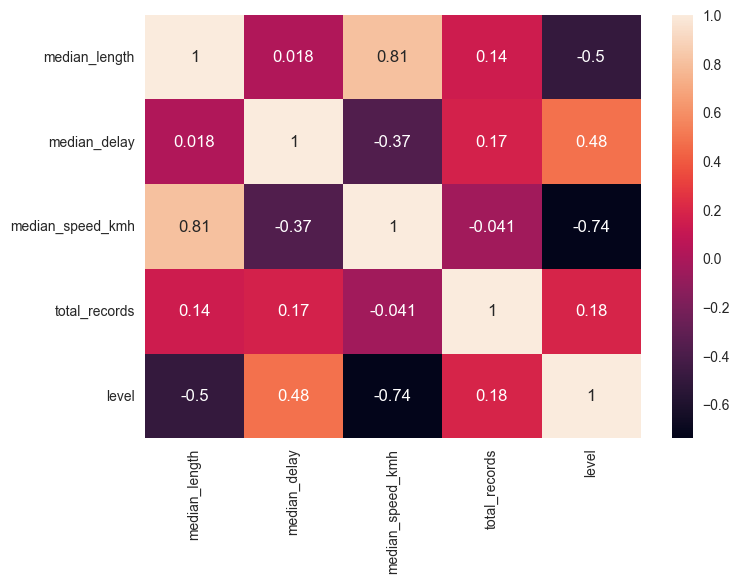

In [9]:
# Melihat korelasi antar feature
sns.heatmap(df1.corr(), annot=True, fmt='.2g')

melalui heatmap diatas maka data 'median_speed_kmh' di hapus karena memiliki nilai korelasi yang tinggi terhadap feature lainnya

In [10]:
del df1['median_speed_kmh']

<Axes: xlabel='median_length'>

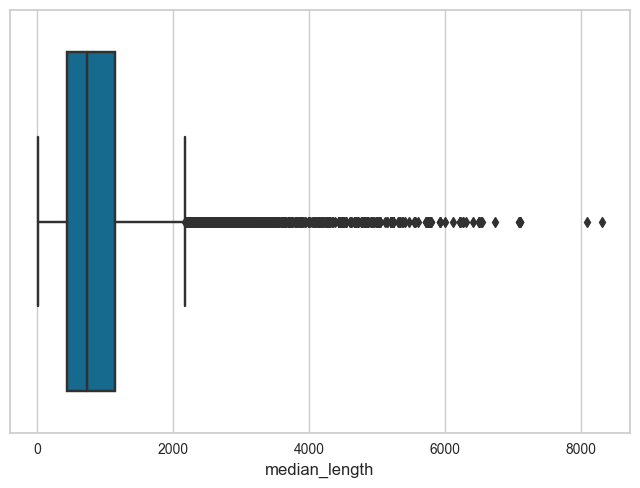

In [11]:
# Melihat outlier 'median_length'
sns.boxplot(x=df1['median_length'])

<Axes: xlabel='total_records'>

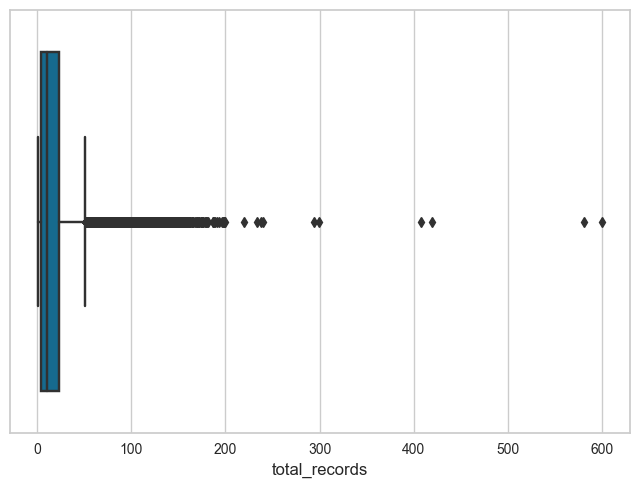

In [12]:
# Melihat outlier 'total_records'
sns.boxplot(x=df1['total_records'])

<Axes: xlabel='median_delay'>

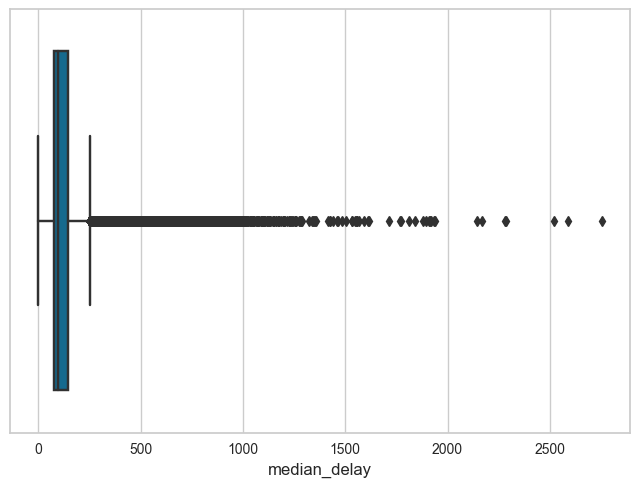

In [13]:
# Melihat outlier 'median_delay'
sns.boxplot(x=df1['median_delay'])

In [14]:
# Function menghapus outlier
def remove_outlier(df):
  q1 = df.quantile(0.25)
  q3 = df.quantile(0.75)
  iqr = q3 - q1
  df_hasil = df[~((df < (q1-1.5*iqr)) | (df > (q3+1.5*iqr)))]
  return df_hasil
     

In [15]:
# menghapus outlier
df_remove = remove_outlier(df1[['median_delay', 'median_length', 'total_records', 'street', 'level']])
df_remove.dropna(axis=0, inplace=True)
     

In [16]:
df_remove

,median_delay,median_length,total_records,street,level
0,62.0,784.0,4.0,Pahlawan,2.0
1,63.0,1314.0,2.0,Tol Lingkar Luar Bogor,2.0
3,117.5,379.0,10.0,N8 Jalan Raya Sukabumi,3.0
6,73.0,808.0,1.0,N9 Jalan Raya Pajajaran,2.0
8,73.0,1771.0,1.0,N9 Jalan Raya Tajur,1.0
...,...,...,...,...,...
102313,85.0,1743.0,1.0,N8 Jalan Raya Bogor,1.0
102314,184.0,1801.0,11.0,N8 Jalan Raya Bogor,2.0
102315,63.0,539.0,7.0,Semplak Raya,2.0
102316,67.0,327.0,9.0,N9 KS Tubun,2.0


## Modelling

In [17]:
# memisahkan data kategorikal dengan numerikal
categorical_features = df_remove.select_dtypes(exclude='number')
numerical_features = df_remove.select_dtypes(exclude='object').reset_index()

In [18]:
# Melabel data jalan menjadi numerik
le = LabelEncoder()
categorical_features_label = le.fit_transform(categorical_features)

In [19]:
# mengubah data menjadi dataframe
df_categorical_features_label = pd.DataFrame(categorical_features_label, columns=['jalan'])

In [20]:
# menggabungkan data numerik dan data kategorik
data = numerical_features
data['jalan'] = df_categorical_features_label

In [21]:
# Memisahkan feature target 
X = data.drop(columns='level', axis=1)
y = data['level']

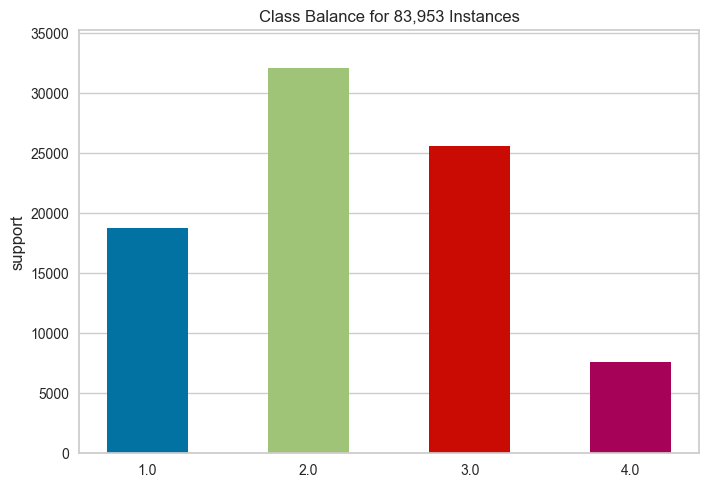

<Axes: title={'center': 'Class Balance for 83,953 Instances'}, ylabel='support'>

In [22]:
# melakukan check untuk melihat proporsi persebaran level kemacetan
check_proporsi = ClassBalance()
check_proporsi.fit(y)
check_proporsi.show()

In [23]:
# split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [24]:
# apply SMOTE oversampling to training data
sm = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

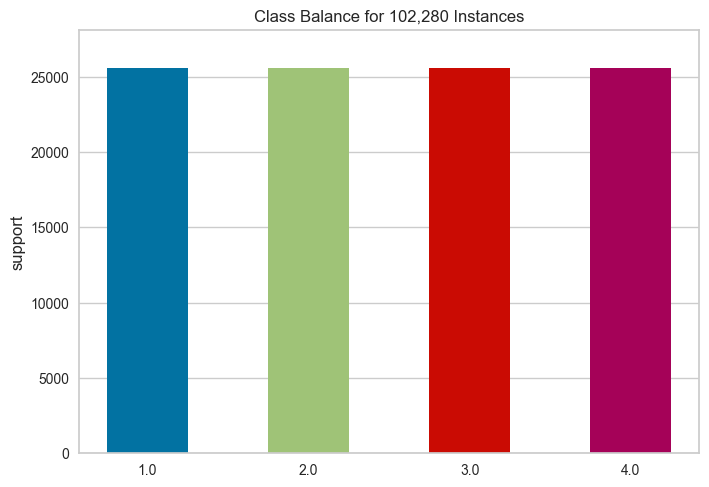

<Axes: title={'center': 'Class Balance for 102,280 Instances'}, ylabel='support'>

In [25]:
# melakukan check untuk melihat proporsi persebaran level kemacetan
check_proporsi = ClassBalance()
check_proporsi.fit(y_train_resampled)
check_proporsi.show()

### KNN

In [26]:
# mencari parameter terbaik
model_pertama = KNeighborsClassifier()
parameter = {
    'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
}
grid_search = GridSearchCV(model_pertama, parameter)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15]})

In [27]:
print('param_terbaik adalah = ', grid_search.best_params_)

param_terbaik adalah =  {'n_neighbors': 1}


In [28]:
model_KNN = KNeighborsClassifier(n_neighbors=1)
model_KNN.fit(X_train_resampled, y_train_resampled)
y_pred_KNN = model_KNN.predict(X_test)

In [29]:
# Hitung akurasi dari model
accuracy = accuracy_score(y_test, y_pred_KNN)
print('Akurasi model: {:.2f}%'.format(accuracy*100))

Akurasi model: 47.27%


### Random Forest

In [30]:
# Inisialisasi model Random Forest dengan n_estimators=100
model_RF = RandomForestClassifier(n_estimators=100)

# Latih model dengan data training
model_RF.fit(X_train_resampled, y_train_resampled)

# Lakukan prediksi dengan data testing
y_pred_RF = model_RF.predict(X_test)

In [31]:
# Hitung akurasi dari model
accuracy = accuracy_score(y_test, y_pred_RF)
print('Akurasi model: {:.2f}%'.format(accuracy*100))

Akurasi model: 83.62%


## Evaluasi Model 

### KNN

In [32]:
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

         1.0       0.43      0.48      0.46      3700
         2.0       0.47      0.46      0.47      6471
         3.0       0.51      0.47      0.49      5148
         4.0       0.47      0.50      0.48      1472

    accuracy                           0.47     16791
   macro avg       0.47      0.48      0.47     16791
weighted avg       0.47      0.47      0.47     16791



### Random Forest

In [33]:
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

         1.0       0.83      0.87      0.85      3700
         2.0       0.85      0.81      0.83      6471
         3.0       0.85      0.83      0.84      5148
         4.0       0.75      0.90      0.82      1472

    accuracy                           0.84     16791
   macro avg       0.82      0.85      0.83     16791
weighted avg       0.84      0.84      0.84     16791



## Kesimpulan

Berdasarkan hasil modelling data yang dilakukan, dapat disimpulkan bahwa model Random Forest lebih baik daripada model KNN dalam memprediksi tingkat kemacetan lalu lintas di kota Bogor. Hal ini terlihat dari nilai akurasi yang dihasilkan, dimana model Random Forest memiliki akurasi sebesar 84% sedangkan model KNN hanya memiliki akurasi sebesar 47%.